## Doctor Right


#### Import Library

In [1]:
import sys
sys.path.append("../modules")
from eda import EDAAnalyzer
from spark_session import SparkManager
from feature_engineering import FeatureEngineer

In [2]:
# Load autoreload extension
%load_ext autoreload
%autoreload 2

#### Constants and config

In [3]:
mx_submits_path = "../data_sample/mx_submits.parquet/"
mx_submits_line_path = "../data_sample/mx_submitsline.parquet/"
cohort_key="767ef4cac69e8a0c77384f6e1414364b"

sample_patient_id = "8aad41f612a7095449888c8050abaeb05fdee65643caa3033542610421d8bd1daaa2c4ce1757401003a1bbcd60948a7aa13eba507a676dea80e0cf76b77dbc95"
features_cols = [
'facility_provider_address_region',
'patient_gender',
'principal_diagnosis_body_part',
'principal_diagnosis_category',
'claim_all_diagnosis_codes',
'claim_total_charge_amount',
'previous_diagnosis_ohe']
exclude_cols = ['patient_id']

most_reapeated_diagnosis_5char = ['Z0000', 'Z1211', 'R0602', 'Z1231', 'R5383', 'R0789', 'K5900', 'G4733', 'Z1159', 'G8929', 'I2510', 
              'R0981', 'J0190', 'Z7189', 'K5730', 'E7800', 'Z7182', 'R9431', 'R1013', 'R1084', 'Z0001', 'Z1389', 
              'M6281', 'E6601', 'G4700', 'Z6852', 'H5213', 'R7989']


### Spark Session

In [4]:
mx_submits_spark_manager = SparkManager(mx_submits_path)
# mx_submits_spark_manager = SparkManager(cohort_key=cohort_key)
# mx_submits_line_spark_manager = SparkManager(mx_submits_line_path)

24/10/17 01:15:18 WARN Utils: Your hostname, Sureshs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.20.9.214 instead (on interface en0)
24/10/17 01:15:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/17 01:15:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### MX SUBMITS

#### EDA

In [5]:
mx_submits_eda = EDAAnalyzer(mx_submits_spark_manager)

In [6]:
mx_submits_eda.display_head()

24/10/10 15:18:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,claim_number,cohort_key,cohort_record_id,attending_provider_npi,billing_provider_address_cbsa_name,billing_provider_address_city,billing_provider_address_county,billing_provider_address_key,billing_provider_address_latitude,billing_provider_address_longitude,...,type_of_bill_frequency_description,vendorname,cycle_id,patient_birth_year,patient_gender,patient_id,patient_location_preferred_latitude,patient_location_preferred_longitude,patient_location_preferred_zipcode,patient_location_preferred_type
0,a6db914db401522b72e75765b0c8915a,f74909ace68e51891440e4da0b65a70c,323f1fff09390aad4c11c4e3c3d694fe,None,"LAS VEGAS-HENDERSON-PARADISE, NV",Henderson,Clark,3005WHORIZONRIDGEPKWYHENDERSONNV89052,35.998154,-115.119797,...,None,cyan,full_20240611,1944,M,e0e2f2ab3660008f963219f5da377d1e16b302a936951c...,None,None,None,NaN
1,28cd641bca90ccc956666d3d427208f2,6e116682aeba6cd8a5341a9bc3b6f020,da4a4cff3fb363e215eca0779812b117,None,"PARSONS, KS",Parsons,Labette,1902SUSHIGHWAY59PARSONSKS67357,37.320053,-95.264801,...,Admit Through Discharge Claim,cyan,full_20240611,1943,F,64bf854d4bc6350af1c5edc74fe816d23d9d9ecc965cae...,37.676598,-95.472107,66720,1.0
2,7c2a727611dca1435166631a665b7f21,767ef4cac69e8a0c77384f6e1414364b,f4048466449529193e43c6231c6b4f80,None,"PHILADELPHIA-CAMDEN-WILMINGTON, PA-NJ-DE-MD",Woodbury,Gloucester,26EREDBANKAVEWOODBURYNJ08096,39.843605,-75.148361,...,Admit Through Discharge Claim,cyan,full_20240611,1971,M,be3296ca5e261d0300048ece4a74ce6d775f3449a77702...,40.227833,-75.240562,19454,1.0
3,6d014626abbddd193950839be7859c43,0e6b9e4a0d9103c5a9c4f1332d38ef53,781bac90c394b3566e29c81dc925ed3d,None,"MONTGOMERY, AL",Montgomery,Montgomery,2055NORMANDIEDRMONTGOMERYAL36111,32.328972,-86.27977,...,Admit Through Discharge Claim,cyan,full_20240611,1946,F,0025ac2b4ff09bd1505307140b30a7c7f53f9645efa5f4...,32.902707,-85.382338,36855,2.0
4,dfd62d19b9ec0891cf714d5d486736d,767ef4cac69e8a0c77384f6e1414364b,adf9dafa1dc75bec5f501c724d275b46,None,"AUSTIN-ROUND ROCK-GEORGETOWN, TX",Austin,Travis,2170WOODWARDSTAUSTINTX78744,30.212395,-97.745186,...,None,cyan,full_20240611,1996,M,59baeef7b06d85ab2f180a860201c2c1e8c931d48b614c...,40.742847,-82.530979,44903,1.0


In [7]:
mx_submits_eda.display_shape()

'Shape of data: rows: 247334, cols: 127'

#### Type conversion

In [8]:
mx_submits_eda.convert_columns_to_float(["claim_total_charge_amount"])

Casted claim_total_charge_amount to float


In [9]:
# column_info_submits = mx_submits_eda.display_column_info()
# column_info_submits.to_csv("../output/column_info_submits.csv")
# column_info_submits

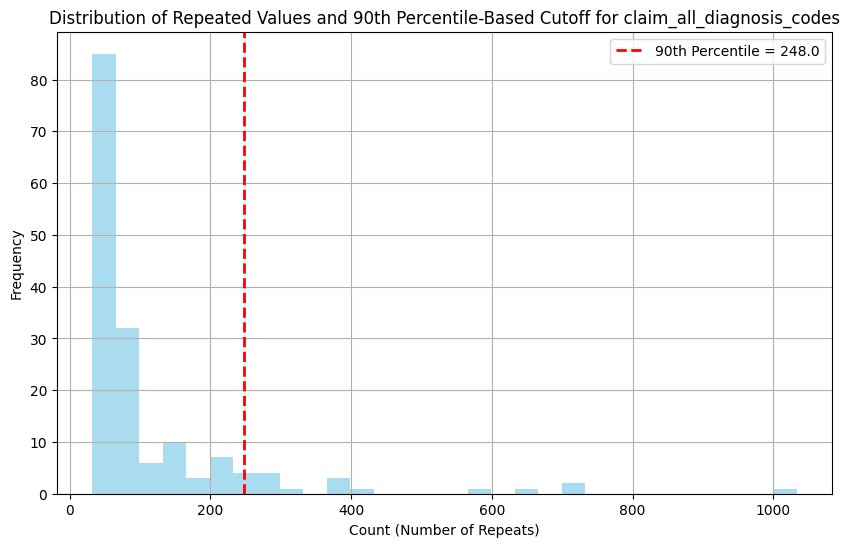

In [10]:
mx_submits_eda.plot_percentile_based_cutoff("claim_all_diagnosis_codes",90,cutoff_length=5, per_patient= True)

In [11]:
mx_submits_claim_all_diagnosis_codes_repeat_count = mx_submits_eda.get_top_n_repeated_values_unique_per_patient("claim_all_diagnosis_codes")
mx_submits_claim_all_diagnosis_codes_repeat_count

,diagnosis_code,count,diagnosis_code_length
0,Z23,2001,3.0
1,I10,1396,3.0
2,Z0000,1302,5.0
3,Z20822,1033,6.0
4,J069,929,4.0
...,...,...,...
13654,82321,1,5.0
13655,N86,1,3.0
13656,S62337A,1,7.0
13657,92232,1,5.0


In [12]:
most_repeated_diagnosis = mx_submits_claim_all_diagnosis_codes_repeat_count[
    (mx_submits_claim_all_diagnosis_codes_repeat_count["diagnosis_code_length"] == 5) & 
    (mx_submits_claim_all_diagnosis_codes_repeat_count["count"] > 248)
]
most_repeated_diagnosis_list = most_repeated_diagnosis['diagnosis_code'].tolist()
most_repeated_diagnosis

,diagnosis_code,count,diagnosis_code_length
2,Z0000,1302,5.0
11,Z1211,708,5.0
16,R0602,617,5.0
17,Z1231,614,5.0
19,R5383,609,5.0
33,R0789,434,5.0
35,K5900,405,5.0
39,G4733,390,5.0
42,Z1159,374,5.0
43,G8929,373,5.0


In [13]:
most_repeated_diagnosis_list

['Z0000',
 'Z1211',
 'R0602',
 'Z1231',
 'R5383',
 'R0789',
 'K5900',
 'G4733',
 'Z1159',
 'G8929',
 'I2510',
 'R0981',
 'J0190',
 'Z7189',
 'K5730',
 'E7800',
 'Z7182',
 'R9431',
 'R1013',
 'R1084',
 'Z0001',
 'Z1389',
 'M6281',
 'E6601',
 'G4700',
 'Z6852',
 'H5213',
 'R7989']

 - (ICD10, Z0001, 1): Encounter for general adult medical examination with abnormal findings
 - (ICD10, F4323, 1): Adjustment disorder with depressed mood
 - (ICD10, Z452, 1)	: Pneumonia, unspecified organism
 - (ICD10, J441, 1)	: Chronic obstructive pulmonary disease with acute exacerbation

In [14]:
mx_submits_eda.get_top_n_repeated_values("claim_all_diagnosis_codes",5)

,claim_all_diagnosis_codes,count,diagnosis_code,diagnosis_code_length
0,"(ICD10, G4733, 1)",4880,G4733,5
1,"(ICD10, I10, 1)",4651,I10,3
2,"(ICD10, I10, 2)",4584,I10,3
3,"(ICD10, Z0000, 1)",3802,Z0000,5
4,"(ICD10, I10, 3)",3740,I10,3


### Feature Engineering

In [5]:
mx_submits_fe=FeatureEngineer(mx_submits_spark_manager)

In [6]:
mx_submits_fe.transform_claim_all_diagnosis_codes()

,claim_all_diagnosis_ohe
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
mx_submits_fe.add_comorbidities_with_exponential_decay_sparse_vector()

,previous_diagnosis_ohe
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
# mx_submits_fe.remove_diagnosis_codes(most_repeated_diagnosis_list)

In [10]:
mx_submits_fe.retain_columns(features_cols)

In [11]:
mx_submits_fe.convert_columns_to_float(["claim_total_charge_amount"])
preprocess_data = mx_submits_fe.preprocess_data(exclude_cols=exclude_cols)
preprocess_data

Casted claim_total_charge_amount to float


One-Hot Encoding applied successfully to column: facility_provider_address_region
One-Hot Encoding applied successfully to column: patient_gender
One-Hot Encoding applied successfully to column: principal_diagnosis_body_part
One-Hot Encoding applied successfully to column: principal_diagnosis_category
Assembling all features into a vector with 6 columns.


Preprocessing complete. Feature vector created.


In [19]:
mx_submits_fe.dataframe.select("features").take(1)[0]["features"].size

13723

In [ ]:
# # mx_submits_fe.reduce_dataframe_size()
# mx_submits_fe.train_autoencoder()
# mx_submits_fe.save_autoencoder("../output/model")

In [ ]:
mx_submits_fe.load_autoencoder("../output/model")

In [ ]:
mx_submits_fe.create_feature_name_map()

In [ ]:
feature_impact = mx_submits_fe.evaluate_feature_impact()
feature_impact

In [ ]:
feature_impact["Feature Name"].to_list()[:300]